# 1. Preparing Data

## 1.1. Importing Libraries

In [2]:
# Importing necessary libraries.
import os
import random
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, classification_report, average_precision_score

import optuna
import matplotlib.pyplot as plt

In [20]:
from dask.distributed import Client

client = Client()

print(client)

C:\Users\callu\anaconda3\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50708 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:50709' processes=4 threads=8, memory=15.92 GiB>


In [39]:
client.close()

## 1.2. Loading Data

In [3]:
# Loading data files.
with open('../../model/documents_dict.json', 'r') as f:
    documents = json.load(f)

with open('../../model/encoded_segments.json', 'r') as f:
    encoded_segments = json.load(f)

with open('../../model/segment_encodings.json', 'r') as f:
    segment_encodings = json.load(f)

with open('../../model/sat_segments_dict.json', 'r') as f:
    sat_segments_dict = json.load(f)

## 1.3. Analysing Data

In [4]:
# Displaying the total number of SATs contributing to all sentences.
total_sats = len(sat_segments_dict)
print(f'Total SATs contributing to all sentences: {total_sats}')

# Filtering SATs with 200 or more values.
filtered_sat_seg_dict = {key: value for key, value in sat_segments_dict.items() if len(value) >= 150}
filtered_sats_count = len(filtered_sat_seg_dict)
print(f'Number of SATs with 200 or more values: {filtered_sats_count}')

Total SATs contributing to all sentences: 329
Number of SATs with 200 or more values: 50


## 1.4. Preprocessing Sentence Embeddings and Labels

In [5]:
# Extracting unique topics and creating mapping from topic names to indices.
topics = list(filtered_sat_seg_dict.keys())
topic_to_idx = {topic: idx for idx, topic in enumerate(topics)}

# Initialising lists to share sentence embeddings (features) and their corresponding labels.
X = []  # List to store embeddings.
y = []  # List to store SAT labels.

# Iterating over each encoded sentence.
for idx, sentence_id in enumerate(encoded_segments):

    # Retrieving the correspeonding embedding for the current sentence.
    embedding = segment_encodings[idx]

    # Initialising a label vector with zeros (one-hot encoding for topics).
    labels = np.zeros(len(topics))

    # Marking relevant labels (topics) for the current sentence.
    for topic, sentences in filtered_sat_seg_dict.items():
        if sentence_id in sentences:
            labels[topic_to_idx[topic]] = 1

    # Including sentences that have at least one associated topic.
    if np.any(labels): 
        X.append(embedding)
        y.append(labels)

# Converting the lists of embeddings and labels into numpy arrays for further processing.
X = np.array(X)
y = np.array(y)

# Displaying the shapes of feature and label arrays to confirm dimensions.
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (9635, 512)
Labels shape: (9635, 50)


## 1.5. Visualizing Label Distribution

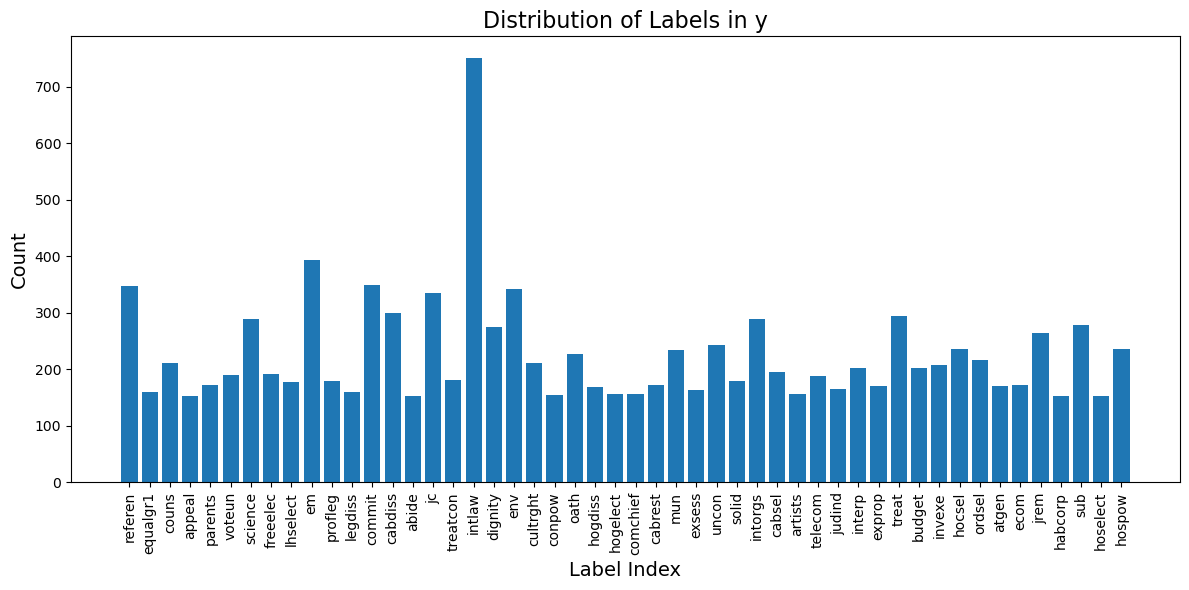

In [6]:
# Calculating the total count of each label across all samples.
label_counts = np.sum(y, axis=0)

# Setting up the figure for the bar chart.
plt.figure(figsize=(12, 6))

# Creating a bar chart to visualise label distribution.
plt.bar(range(len(label_counts)), label_counts)

# Adding chart title and acis labels for clarity.
plt.title('Distribution of Labels in y', fontsize=16)
plt.xlabel('Label Index', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Setting x-axis tick labels to represent topics.
plt.xticks(range(len(label_counts)), topics, rotation=90) 

# Adjusting layout and presenting bar chart.
plt.tight_layout()
plt.show()

## 1.6. Splitting Data into Training and Testing Sets

In [7]:
# Splitting the data into training and testing sets.
train1_x, test_x, train1_y, test_y = train_test_split(X,               # Feature array (embeddings).
                                                      y,               # Label array (one-hot encoded SAT labels).
                                                      train_size=0.9,  # Proportion of data to allocate to training.
                                                      test_size=0.1,   # Proportion of data to allocate to testing.
                                                      random_state=42) # Ensures reproducability by fixing the random seed.

# 2. Training Neural Network

## 2.1. Creating Neural Network Framework

In [8]:
def objective(trial):
    # Clear the backend session to reset any existing Keras state before starting a new trial.
    keras.backend.clear_session()

    # Split the training data further into training and validations sets.
    train_x, valid_x, train_y, valid_y = train_test_split(train1_x,        # Feature array (embeddings).
                                                          train1_y,        # Label array (one-hot encoded SAT labels).
                                                          train_size=0.9,  # Proportion of data to allocate to training.
                                                          test_size=0.1,   # Proportion of data to allocate to testing.
                                                          random_state=42) # Ensures reproducability by fixing the random seed.

    # Define the numver of hidden layers (suggested by Optuna).
    n_layers = trial.suggest_int('n_layers', 1, 5)
    model = keras.Sequential() # Initialise a sequential mode.

    # Input layer matching the feature dimensions.
    model.add(keras.Input(shape=(X.shape[1],)))

    # Dynamically adding hidden layers based on numbers suggested by trial.
    for i in range(n_layers):
        
        # Number of units in hidden layer suggested by Optuna).
        num_hidden = trial.suggest_int(f'n_units_l{i}', 48, len(X[0]), log=True)

        # Activation function for the layer (chosen from a categorical list).
        activation_func = trial.suggest_categorical(f'activation{i}', ['relu', 'linear', 'swish', 'tanh', 'elu', 'selu'])

        # Dropout rate for regularisation (suggested as a float within a range).
        dropout_rate = trial.suggest_float(f'dropout{i}', 0.01, 0.1)

        # Add the dense (fully connected) layer.
        model.add(layers.Dense(num_hidden, activation=activation_func))

        # Add dropout for regularisation.
        model.add(layers.Dropout(rate=dropout_rate))

    # Output layer with one unit per label and sigmoid activation for mtuli-label classification.
    model.add(layers.Dense(y.shape[1], activation='softmax'))

    # Learning rate (suggested as a float within a logarithmic range).
    learning_rate = trial.suggest_float('learning_rate', 0.0003, 0.0006, log=True)

    # Compile the model with binary cross-entropy loss, accuracy metric, and the Adam optimiser.
    model.compile(
        loss='binary_crossentropy', 
        metrics=['accuracy'], 
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )

    # Callbacks for learning rate reduction and early stopping to prevent overfitting.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-5, verbose=0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)

    # Training the model on the training data with validation, using sugegsted batch size.
    history = model.fit(
        train_x, train_y, 
        validation_data=(valid_x, valid_y), 
        epochs=200, 
        batch_size=trial.suggest_int('size', 8, 512), 
        callbacks=[reduce_lr, early_stopping], 
        verbose=0 # Surpress verbose output during trials.
    )

    # Return the minimum validation loss achieved during training as the optimisation target.
    return min(history.history['val_loss'])

## 2.2. Hyperparameter Optimisation

In [ ]:
if __name__ == "__main__":
    # Create an optuna study to minimise the bojective function.
    study = optuna.create_study(direction="minimize")

    # Optimise the objective function over 2000 trials, with a time out of 12000 seconds.
    study.optimize(objective, n_trials=5, timeout=12000, n_jobs=1)

    # Print details of the number of trials finished, and the best trial.
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))

[I 2025-01-23 11:42:25,194] A new study created in memory with name: no-name-371123d2-5551-4388-aec3-a40b55563fa6


# 3. Visualisation

## 3.1. Optimisation History

In [ ]:
# Visualise the optimisation history.
poh = optuna.visualization.plot_optimization_history(study)
poh.update_layout(width=1000, height=600)  # Adjust the width and height as needed
poh.show()

## 3.2. Parallel Coordinates

In [ ]:
# Visualise the parallel coordinate.
ppc = optuna.visualization.plot_parallel_coordinate(study)
ppc.update_layout(width=1000, height=600)  # Adjust the width and height as needed.
ppc.show()

## 3.2. Slice

In [ ]:
ps = optuna.visualization.plot_slice(study)
ps.update_layout(width=1000, height=600)  # Adjust the width and height as needed.
ps.show()

## 3.2. Parameter Importance

In [ ]:
# Create an interactive plot for parameter importances
ppi = optuna.visualization.plot_param_importances(study)
ppi.update_layout(width=1000, height=600)  # Adjust the width and height as needed.
ppi.show()

## 3.3. Best Parameters

In [ ]:
# Print parameters of the best trial.
print("  Params: ")
for key, value in trial.params.items():
    # Print each parameters name and its corresponding value.
    print("    {}: {}".format(key, value))

In [ ]:
def final_model():
    model = keras.Sequential()
    
    n_layers = trial.params['n_layers']
    # Add the input layer with input shape explicitly.
    num_hidden = trial.params['n_units_l0']
    activation_func = trial.params['activation0']
    dropout_rate = trial.params['dropout0']
    
    model.add(keras.layers.Input(shape=(X.shape[1],)))  # Explicit input layer.
    model.add(keras.layers.Dense(num_hidden, activation=activation_func))
    model.add(keras.layers.Dropout(dropout_rate))
    
    for i in range(1, n_layers):  # Start from the second layer since the first is added above.
        num_hidden = trial.params[f'n_units_l{i}']
        activation_func = trial.params[f'activation{i}']
        dropout_rate = trial.params[f'dropout{i}']
        
        model.add(keras.layers.Dense(num_hidden, activation=activation_func))
        model.add(keras.layers.Dropout(dropout_rate))
    
    model.add(keras.layers.Dense(y.shape[1], activation='sigmoid'))
    
    learning_rate = trial.params['learning_rate']
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    return model

def calculate_map(y_true, y_pred):
    # Average Precision score is calculated per label and then averaged.
    map_score = 0
    for i in range(y_true.shape[1]):  # Loop through each label.
        # For each label, calculate the Average Precision score.
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        map_score += ap
    
    # Return the Mean Average Precision by averaging the individual AP scores.
    return map_score / y_true.shape[1]

In [ ]:
model = final_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

history = model.fit(train1_x, train1_y, validation_data=(test_x, test_y), epochs=200, 
                    batch_size=trial.params['size'],
                    callbacks=[reduce_lr, early_stopping], verbose=1)

model.save("final_model.h5")
print("Final model saved to 'final_model.h5'")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

np.save("history.npy", history.history)

In [ ]:
def calculate_map_per_label(y_true, y_pred):
    """
    Calculate the Mean Average Precision (mAP) for each label individually.
    """
    ap_scores = []
    for i in range(y_true.shape[1]):  # Loop through each label
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        ap_scores.append(ap)
    return ap_scores

In [ ]:
# Ensure predictions are generated before calculating mAP scores
test_predictions = model.predict(test_x)

# Calculate mAP scores for each label using the provided function
map_scores_per_label = calculate_map_per_label(test_y, test_predictions)

# Calculate the sum of true values for each label
label_counts = np.sum(test_y, axis=0)

# Calculate the percentage of the dataset for each label
label_percentages = (label_counts / len(test_y)) * 100

# Create a DataFrame to organize and display the data
map_table = pd.DataFrame({
    "Label": topics,
    "(mAP)": map_scores_per_label,
    "(%)": label_percentages
})

# Sort the table by percentages (ascending order), since we want the bars ordered by size
map_table = map_table.sort_values(by="(%)", ascending=False, ignore_index=True)